(600, 4)
[105.32682305  38.55381872  24.7042342   24.51866362]
[0.80438377 0.10777552 0.04425151 0.0435892 ]


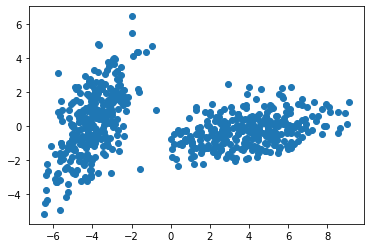

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

np.random.seed(12345678)

N=300
X = np.concatenate( (
    np.random.multivariate_normal([0,0,0,0], [[1,0,0,0],[0,4,1,0],[0,1,1,0],[0,0,0,1]], size=N),
    np.random.multivariate_normal([0,8,0,0], [[1,0,0,0],[0,1,1,0],[0,1,4,0],[0,0,0,1]], size=N),
) )

pca = PCA(n_components=4)
Y = pca.fit_transform(X)
print(X.shape)
print(pca.singular_values_) 
print(pca.explained_variance_ratio_)
plt.scatter(Y[:,0], Y[:,1])
plt.show()

### PCA

Shown above is an example of PCA reducing a 4 dimensional dataset to a 2-dimensional one. Some brief notes on how this works. More detail [here](https://arxiv.org/pdf/1404.1100.pdf)

Let's say we have $N$ data points measuring $p$ features. We can arrange them into a data matrix
$$
X = \begin{pmatrix} 
x_{11} & x_{12} & \ldots & x_{1p} \\ 
x_{21} & x_{22} & \ldots & x_{2p} \\
\ldots \\
x_{N1} & x_{N2} & \ldots & x_{Np} \\
\end{pmatrix}
= \begin{pmatrix} 
\mathbf{x_1} & \mathbf{x_2} & \ldots & \mathbf{x_p} 
\end{pmatrix}
$$
I have written $X$ as an $N \times p$ matrix, note (to my endless confusion) this is not always the way it is written in maths books. $\mathbf{x_i}$ is a (column) vector consisting of the values of the ith feature for every observation. The mean of each column is
$$
\mu_i = \frac{1}{N} \sum_j^N x_{ji}
$$
Subtract this from each column
$$
X' = \begin{pmatrix} 
x_{11}-\mu_1 & x_{12} -\mu_2& \ldots & x_{1p} -\mu_p\\ 
x_{21}-\mu_1 & x_{22} -\mu_2& \ldots & x_{2p} -\mu_p\\
\ldots \\
x_{N1}-\mu_1 & x_{N2} -\mu_2& \ldots & x_{Np} -\mu_p\\
\end{pmatrix}
=
\begin{pmatrix}
\mathbf{x_1}' & \mathbf{x_2}' & \ldots & \mathbf{x_p}' 
\end{pmatrix}
$$
We note that
$$
\mathbf{x_1}' \cdot \mathbf{x_1}' = \sum_j (x_{j1}-\mu_1)^2 = c_{11}
$$
is the variance along the 1-dimension. Similarly
$$
\mathbf{x_1}' \cdot \mathbf{x_2}' = \sum_j (x_{j1}-\mu_1) (x_{j2}-\mu_2) = c_{12} = c_{21}
$$
Is the covariance (think correlation coefficient...) of the data between dimensions 1 and 2. We can record all of the variances and covariances in a nice matrix form
$$
C_X = \frac{1}{N} X'^T X' = 
\begin{pmatrix}
\mathbf{x_1}' \\ \mathbf{x_2}' \\ \ldots \\ \mathbf{x_p}' 
\end{pmatrix}
\begin{pmatrix}
\mathbf{x_1}' & \mathbf{x_2}' & \ldots & \mathbf{x_p}' 
\end{pmatrix}
=
\begin{pmatrix} 
c_{11} & c_{12} & \ldots & c_{1p}\\ 
c_{21} & c_{22} & \ldots & c_{2p}\\
\ldots \\
c_{p1} & c_{p2}& \ldots & c_{pp}\\
\end{pmatrix} 
$$


 1. Large values on the diagonal correspond to interesting stuff. Think about it this way, if the variance was small, then the measurements in that direction would all be the same, so there's very little information in that component.
 2. Large values on the off diagonal correspond to features which are related. The covariance is almost equivalent to the (Pearson) correlation coefficient. A high value of $c_{ij}$ means that the measurement of $j$ doesn't give much extra information that wasn't already obtained by knowing $i$.
An "ideal" covariance matrix would be diagonal (no correlations) and have only a few large variances (so we don't have to measure all of the features). PCA is a transformation that tries to accomplish this. 

(Assuming you know a bit of linear algebra here...)
**Find P such that**
$$
C_Y = P^T C_X P
$$
**is diagonal.**
This can be accomplished by the eigenvector decomposition of $C_X$ or the Singular Value Decomposition of $X$ (which is what is usually used)
$$
X = U \Sigma V^T
$$
$U$ is $N \times N$, $\Sigma$ is $N \times p$ and diagonal and $V$ is $p \times p$. $U$ and $V$ are orthogonal. Rearranging gives
$$
X V = \Sigma U
$$
By multiplying on the right by $V$ the matrix $X$ is transformed into a new basis where the covariance matrix is nicer.

Note that this only accomplishes the 2nd goal. The first goal depends on the data. If you really have a situation where each measurement is giving you unique information then you can't expect to reduce the dimensionality. However, in this new basis, it is much easier to see if you have directions which aren't so important
$$
X V = U \Sigma = 
\begin{pmatrix}
\mathbf{u_1} & \mathbf{u_2} & \ldots & \mathbf{u_N}\\
\end{pmatrix}
\begin{pmatrix}
\sigma_1 & 0 & \ldots & 0 \\
0 & \sigma_2 & \ldots & 0 \\
\vdots \\
0 & 0 & \ldots & \sigma_p \\
\vdots \\
0 & 0 & \ldots & 0
\end{pmatrix} = 
\sigma_1 \mathbf{u_1} + \sigma_2 \mathbf{u_2} + \ldots + \sigma_p \mathbf{u_p}
$$
If say $\sigma_k \gg \sigma_{i > k}$ then we don't lose too much by truncating the sum after $k<p$ terms.


In [2]:
from time import time
from sklearn.decomposition import TruncatedSVD

p = 20
N = 20000
s = np.random.uniform( 0,1,(p,p))
s = s.dot( s.T )
m = np.zeros(p)
X = np.random.multivariate_normal(m, s, size=N)


def time_PCA(X, ncpt, method, trunc=False):
    if trunc:
        t0 = time()
        pca = TruncatedSVD(n_components=ncpt, algorithm=method)
        Y = pca.fit_transform(X)
        t1 = time()
        return t1 - t0        
    else:
        t0 = time()
        pca = PCA(n_components=ncpt, svd_solver=method)
        Y = pca.fit_transform(X)
        t1 = time()
        return t1 - t0
    
ncpt = 2  
Nsamples = 100
for m in ['full', 'arpack', 'randomized']:
    times = np.array([ time_PCA(X, ncpt, m) for i in range(Nsamples) ])
    print("Full\t Method =", m, " Time:", np.mean(times), "+/-", np.std(times))
    if m != "full":
        times = np.array([ time_PCA(X, ncpt, m, trunc=True) for i in range(Nsamples) ])
        print("Truncated\tMethod =", m, " Time:", np.mean(times), "+/-", np.std(times))
    

Full	 Method = full  Time: 0.015918209552764892 +/- 0.005932202234066889
Full	 Method = arpack  Time: 0.009492454528808593 +/- 0.006888149138177633
Truncated	Method = arpack  Time: 0.006875576972961425 +/- 0.002307716877916599
Full	 Method = randomized  Time: 0.042120594978332516 +/- 0.010440278394317694
Truncated	Method = randomized  Time: 0.0736674690246582 +/- 0.033356173753995653


See [this talk](https://www.youtube.com/watch?v=koTf7u0v41o) for important advice about timing your code. For these fake matrices it doesn't seem like the method used to compute the SVD makes much difference. Which is good because explaining them would be complicated. The fact the randomized version is not way faster is surprising, as p increases it becomes faster, but not by that much... 

There is another version called TruncatedSVD. The only difference (from what I can tell) is that it doesn't do the mean subtraction and it has no "full" option.

### Locally Linear Embedding

The problem with PCA is that it is global. So complicated curves that fold a lot (think pastry) just don't work. LLE is like doing PCA in small patches and gluing them all together in the end.

**Step 1:** Choose a data point $x_i$ and imagine we had some weights that could reconstruct it from its $K$ nearest neighbours
$$
x_i = \sum_j w_{ij} x_j
$$
Where the weights are 0 unless $j$ is one of the nearest neighbours. Doing this for every data point and averaging the error gives
$$
E(w) = \sum_i (x_i - \sum_j w_{ij} x_j)^2
$$
Step 1 is to find $w$ by minizing this error. We also enforce that the row sums of $w$ equal 1. 


**Unnecessary details** This is done in the following way.
For a particular data point where the neighbour vectors are called $v$ for clarity 
$$
e = (x - \sum_j w_j v_j)^2 = (\sum_j w_j(x - v_j) )^2 = \sum_{jk} w_j (x - v_j) (x - v_k) w_k
$$
(second step uses $\sum_j w_j = 1$). With $C_{jk} = (x - v_j) (x - v_k)$ and enforce the constraint with a Lagrange multiplier
$$
e = \sum_{jk} w_j C_{jk} w_k - \lambda (\sum_j w_j - 1)
$$
$$
\frac{de}{dw_i} = \sum_k C_{ik} w_k - \lambda  = 0
$$
$$
w_k = C^{-1}_{ik} \lambda
$$
We then choose $\lambda$ to enforce the normalisation constraint. In practice just solve
$$
\sum_k C_{ik} w_k  = 1
$$
with standard methods and then normalise $w$.

**Step 2:** Ok, we've got $w$ now what? The idea is that the same weights that work in high dimensions should also work in low dimensions. That is it should be possible to reconstruct low dimensional vectors from weighted combinations of their neighbours
$$
y_i = \sum_{j} w_{ij} y_j
$$
We solve this with fixed $w$ to find the $y$s by minimising
$$
\sum_i (y_i - \sum_{j} w_{ij} y_j)^2
$$

**Unnecessary details** This is done in the following way. Rewrite the thing to be minimised
$$
\sum_i (y_i - \sum_{j} w_{ij} y_j)^2 = \sum_{ij} y_i M_{ij} y_j
$$
Where
$$
M_{ij} = (I - W)(1-W)^T
$$
By the Rayleigh-Ritz Theorem the first k eigenvectors minimise the ratio
$$
\frac{y^TMy}{y^Ty}
$$
So basically $y$ are just the eigenvectors of $w$.

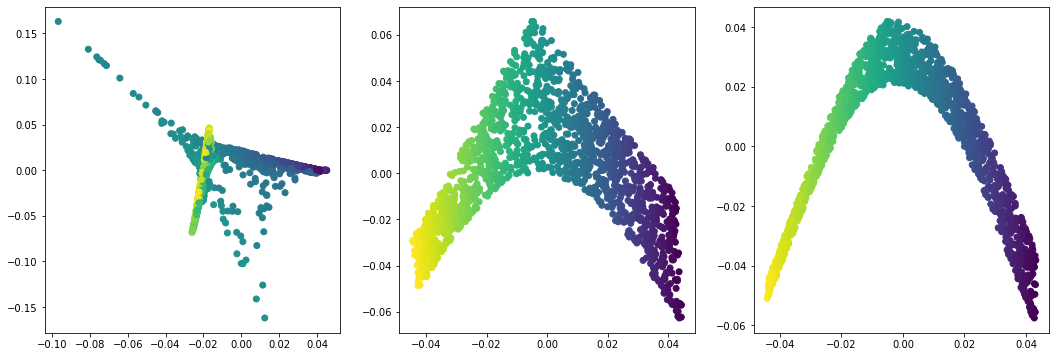

In [3]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn import datasets

n_samples = 1500
S_points, S_color = datasets.make_s_curve(n_samples, random_state=0)

fig, ax = plt.subplots(1,3,figsize=(18,6))
for i,nn in enumerate([6,12,30]):
    lle_standard = LocallyLinearEmbedding(method="standard", n_neighbors=nn)
    Y = lle_standard.fit_transform(S_points)

    ax[i].scatter(Y[:,0], Y[:,1], c=S_color)

plt.show()

Note the weird behaviout for $nn = 6$ this seems to be too small to capture smoothness in the original data. There is also a problem with large numebr of neighbours, when the number of neighbors is greater than the number of input dimensions the matrix defining each local neighborhood is rank-deficient. Various (complicated) schemes exist to fix this. By default a regularisation (add a constant) is applied and seems to work ok but there is no guarantee.

### Spectral Methods

This is another PCA-like method, but the object you do PCA to isn't the data/covariance matrix, it's a graph Laplacian.

**Assuming you know some graph theory otherwise skip**

For a graph $G$ let it's adjacency matrix be $A$ and it's degree matrix (that is a diagonal matrix with the degrees on the diagonal) be $D$. We turn a bunch of points into a graph by
 - joining all points whose pairwise distance is $\epsilon$
 - joining $K$ nearest neighbours
 - Using a Gaussian kernel $s(i,j) = \exp\left( -\frac{|x_i - x_j|^2}{2\sigma^2} \right)$ see [this](https://proceedings.neurips.cc/paper_files/paper/2001/file/801272ee79cfde7fa5960571fee36b9b-Paper.pdf)
 
Mathemathicians like to use the Laplacian instead of the adjacency matrix (other definitions exist)
$$
L = D - A
$$
This is because $L$ has some nice properties.
 - if $e$ is a vector of all 1s, then $Le = 0$, so 0 is an eigenvalue.
 - L is symmetric positive semidefinite $x^T L X \geq 0$
 - These imply real positive eigenvalues $0 = \lambda_1 \leq \lambda_2 \leq \ldots \lambda_n$
 
#### Key result
$$
x^T L x = \sum_{i} d_i x_i^2 - \sum_{ij} a_{ij} x_i x_j
$$
using
$$
\sum_{i} d_i  x_i^2 = \sum_{ij} a_{ij} x_i^2
$$
along with the symmetry of $A$ and changing some indices
$$
x^T L x = \frac{1}{2}\sum_{ij} a_{ij} (x_i - x_j)^2
$$
Assume $x$ is an eigenvector with eigenvalue 0. This means
$$
x^T L x = \frac{1}{2}\sum_{ij} a_{ij} (x_i - x_j)^2 = 0
$$
which implies if $i$ is connected to $j$ then we must have $x_{i} = x_j$. Namely, eigenvectors must be constant on a connected component. This means if there are $K$ components of the graph there must be $K$ eigenvectors which are constant on those nodes, with eigenvalue 0.

Spectral clustering then consists of finding the $K$ lowest eigenvectors of the Laplacian and hoping that there are $K$ components.

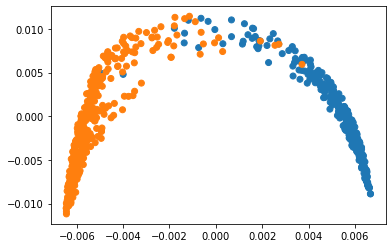

In [4]:
from sklearn.manifold import SpectralEmbedding

np.random.seed(12345678)

N=300
X = np.concatenate( (
    np.random.multivariate_normal([0,0,0,0], [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]], size=N),
    np.random.multivariate_normal([2,2,2,2], [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]], size=N),
) )

col = ['C0']*N + ['C1']*N
se = SpectralEmbedding(n_components=2)
Y = se.fit_transform(X)
plt.scatter(Y[:,0], Y[:,1], c=col)
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


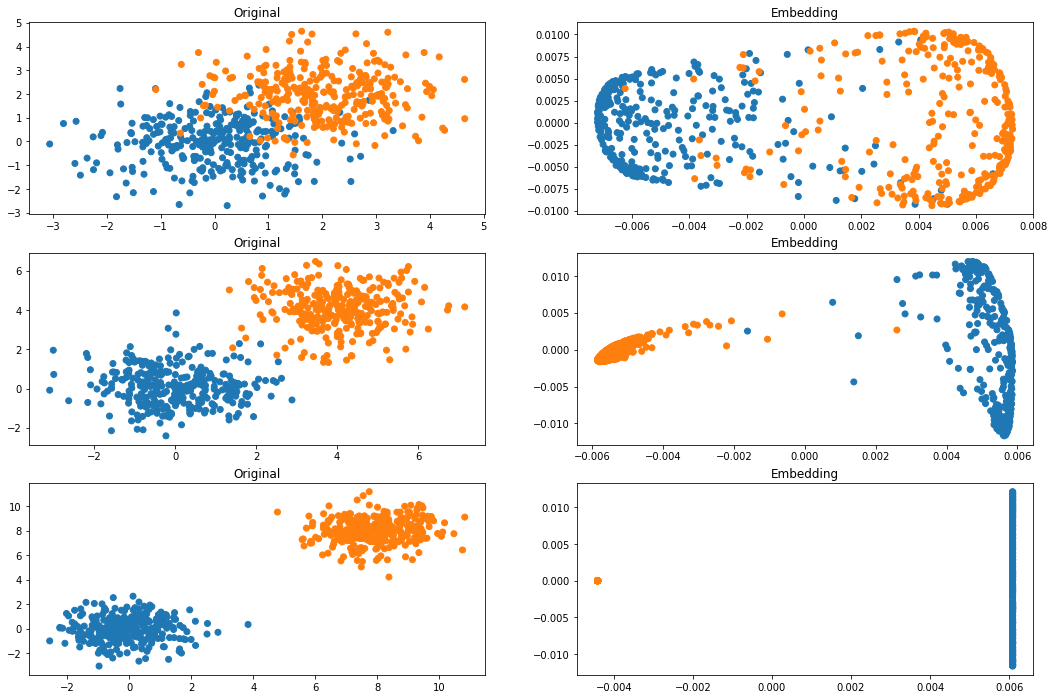

In [5]:
N=300
fig, ax = plt.subplots(3,2, figsize=(18,12))

for i, d in enumerate([2,4,8]):

    X = np.concatenate( (
        np.random.multivariate_normal([0,0], [[1,0],[0,1]], size=N),
        np.random.multivariate_normal([d,d], [[1,0],[0,1]], size=N),
    ) )
    col = ['C0']*N + ['C1']*N
    ax[i][0].scatter(X[:,0], X[:,1], c=col)
    ax[i][0].set_title("Original")
    se = SpectralEmbedding(n_components=2)
    Y = se.fit_transform(X)
    ax[i][1].scatter(Y[:,0], Y[:,1], c=col)
    ax[i][1].set_title("Embedding")

plt.show()

The above shows that if the blobs are too far apart, you get some weird behaviour in this implementation.

### t-SNE

A very popular algorithm that basically trys to make the probability of $i$ and $j$ being neighbours the same in a low dimensional representation as a high dimensional one.

From the data we compute
$$
P(j|i) \propto \exp\left( |x_i-x_j|^2/2\sigma_i^2 \right)
$$
then
$$
p_{ij} = \frac{1}{2}(P(j|i) + P(i|j))
$$

We want to construct a (low dimensional) representation $y_i$ as
$$
Q(j|i) \propto \left(1 - |x_i-x_j|^2 \right)^{-1}
$$
This is a t-distribution, hence the $t$ in the name. With
$$
q_{ij} = \frac{1}{2}(Q(j|i) + Q(i|j))
$$

The game is to find $y$ so that $p$ and $q$ are close, where this is measured by the KL-Divergence
$$
D(p|q) = \sum p_{ij} \log\frac{p_{ij}}{q_{ij}}
$$
$y$ is found by gradient descent. The gradient requires differentiating $D$, which I don't want to do, and takes $O(N^2)$ operations, which is very slow. Scikit implements a nice version using [Quadtrees](https://en.wikipedia.org/wiki/Quadtree), see also [this](https://en.wikipedia.org/wiki/Barnes%E2%80%93Hut_simulation). You should use this version!


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default lea

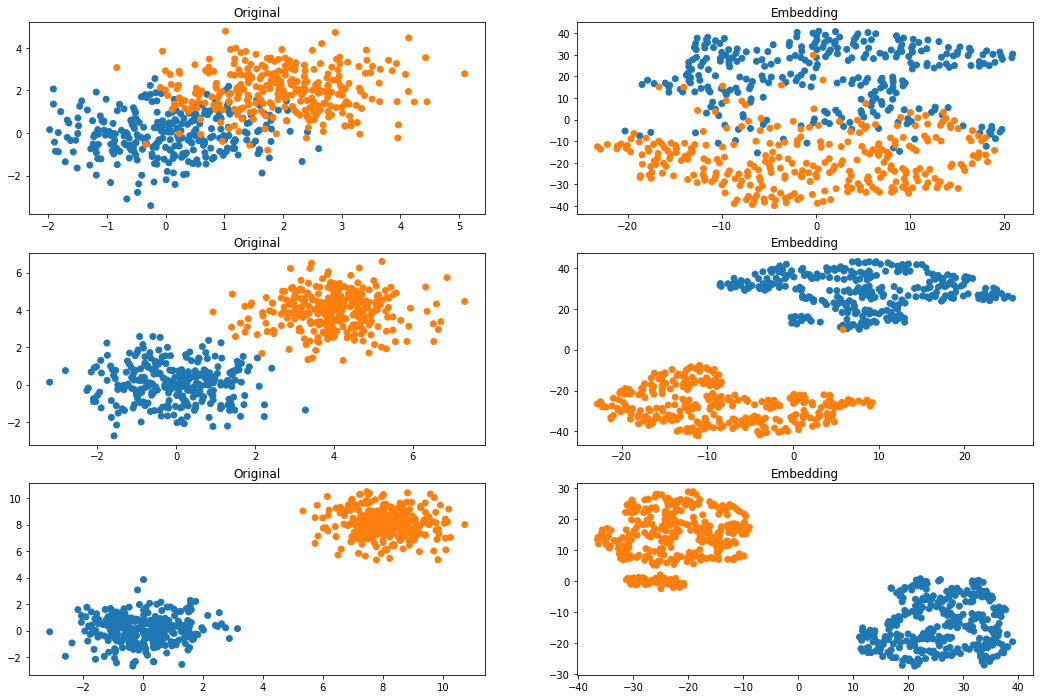

In [6]:
from sklearn.manifold import TSNE

np.random.seed(12345678)

N=300
fig, ax = plt.subplots(3,2, figsize=(18,12))

for i, d in enumerate([2,4,8]):

    X = np.concatenate( (
        np.random.multivariate_normal([0,0], [[1,0],[0,1]], size=N),
        np.random.multivariate_normal([d,d], [[1,0],[0,1]], size=N),
    ) )
    col = ['C0']*N + ['C1']*N
    ax[i][0].scatter(X[:,0], X[:,1], c=col)
    ax[i][0].set_title("Original")
    se = TSNE(n_components=2)
    Y = se.fit_transform(X)
    ax[i][1].scatter(Y[:,0], Y[:,1], c=col)
    ax[i][1].set_title("Embedding")

plt.show()

### Timing

The asymptotic scaling with number of data points for these algorithms is given [here](https://scikit-learn.org/stable/modules/manifold.html). Let's see how it works out on some examples...

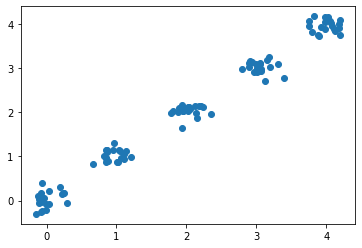

In [7]:
def gen_clusters(p, c, M):
    s = np.diag( np.random.normal( 0.02,0.0,p) )
    X = np.empty( (M*c,p) );
    for i in range(c):
        X[M*i:M*(i+1), :] = np.random.multivariate_normal(np.ones(p)*i, s, size=M)
    return X

p = 2 ##number of dimensions
c = 5 ##number of clusters
M = 20 #total number of points per cluster
N = M*c

X = gen_clusters(p, c, M)
plt.scatter(X[:,0], X[:,1])
plt.show()

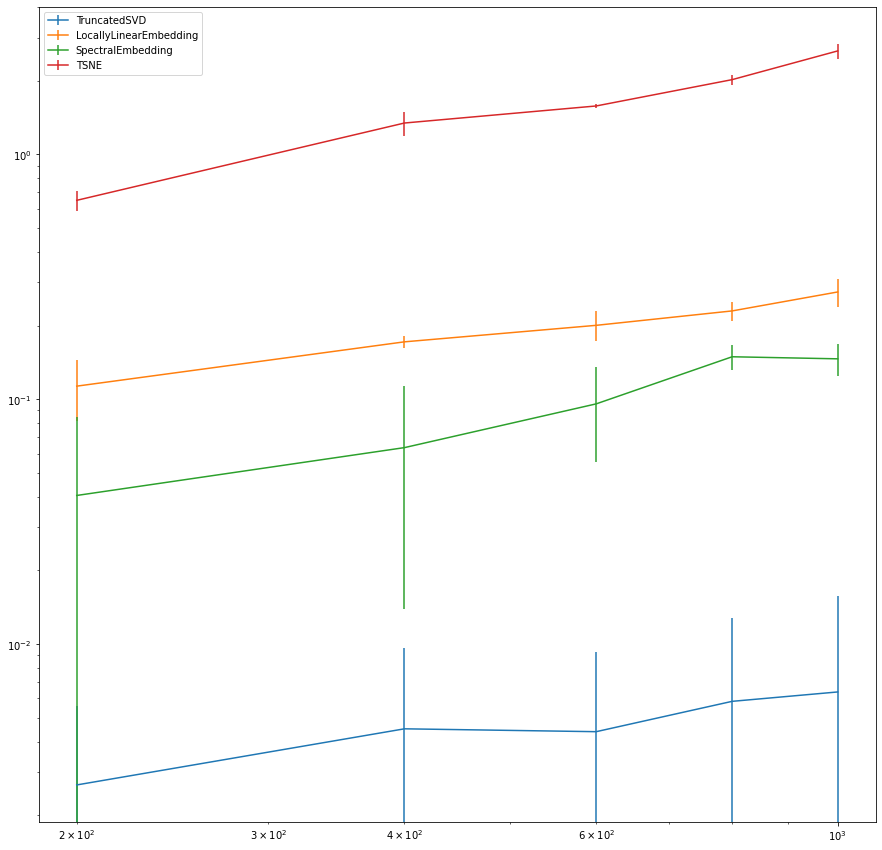

In [8]:
p = 20 ##number of dimensions
c = 10 ##number of clusters
Ns = 10 ##for estimating variance in code execution time

import warnings
warnings.filterwarnings('ignore') #update your scikit version Rudy

plt.figure(figsize=(15, 15))

methods = {
"TruncatedSVD": TruncatedSVD(n_components=2),
"LocallyLinearEmbedding": LocallyLinearEmbedding(n_components = 2, n_neighbors=5, eigen_solver='dense'),
"SpectralEmbedding": SpectralEmbedding(n_components=2, affinity='rbf'), 
"TSNE": TSNE(n_components=2, init='pca', learning_rate='auto')    
}
times = {m:[] for m in methods}

def ft(reducer):
    t0 = time()
    Y = reducer.fit_transform(X)
    t1 = time()
    return t1-t0

Ms = np.array([20,40,60,80,100])#,160,320,640,1280])
for M in Ms:
    N = M*c

    X = gen_clusters(p, c, M)

    for m, dimred in methods.items():
        times[m].append( [ ft(dimred) for i in range(Ns)]  )

for m, v in times.items():
    x = Ms*c
    y = np.array([np.mean(c) for c in v])
    err = np.array([np.std(c) for c in v])
    plt.errorbar(x, y, yerr=err, label=m)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

Note this is a log-log scale. PCA is an order of magnitude faster than LLE or Spectral and 2 orders of magnitude (100x) faster than TSNE. Unfortunately TSNE seems to perform really well at creating good dimensional reductions and PCA is not so good. LLE and Spectral may be good compromises between quality and speed, though they are also a bit flaky, and require getting their parameters right. For example, local linear approximation can go faster if the solver is not fixed to "dense", but it kept crashing otherwise. Setting to arpack makes it faster than the spectral method. Scaling the data may help, but the above LLE and Spectral methods give totally weird results when plotted.

(1797, 64)


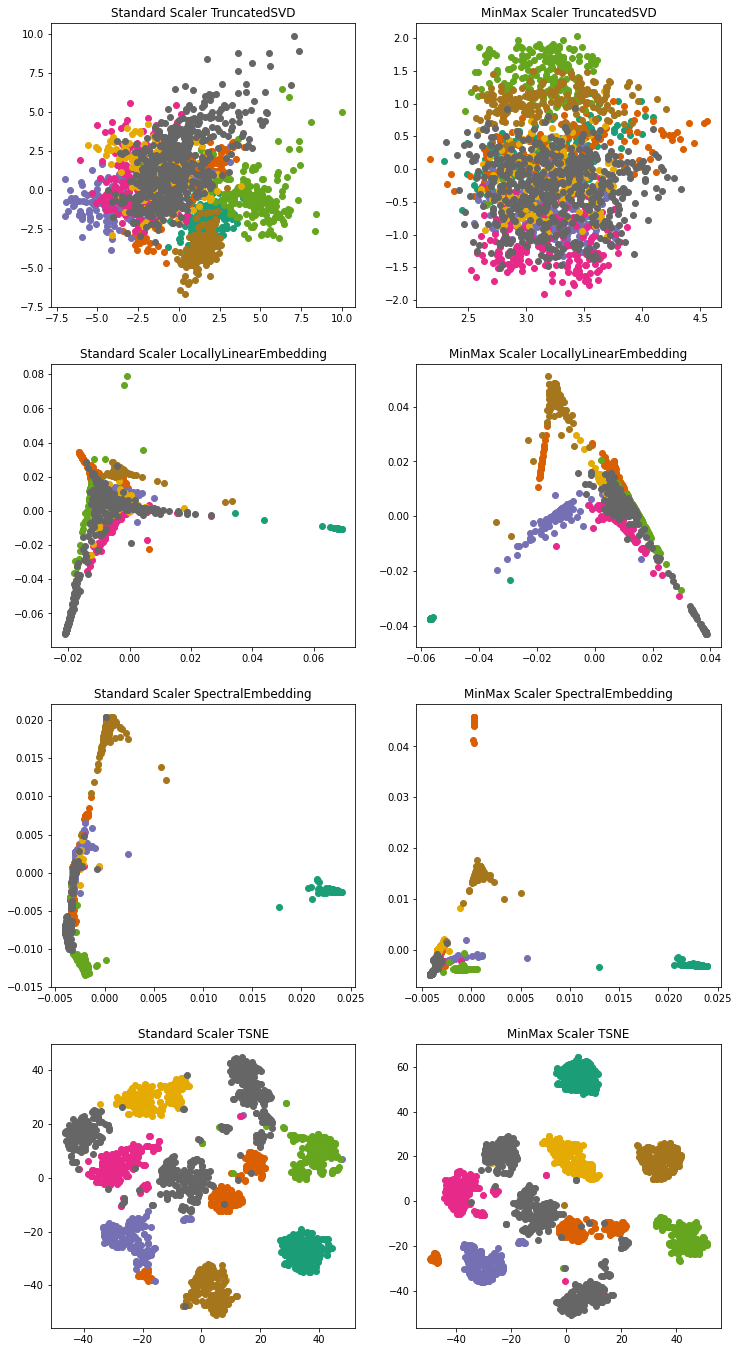

In [74]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler, StandardScaler

digits = load_digits()
X, y = digits.data, digits.target
Xss = StandardScaler().fit_transform(X)
Xmm = MinMaxScaler().fit_transform(X)

n_neighbors = 10

print(X.shape)
fig, ax = plt.subplots(4,2,figsize=(12, 24))

methods = {
"TruncatedSVD": TruncatedSVD(n_components=2),
"LocallyLinearEmbedding": LocallyLinearEmbedding(n_components = 2, n_neighbors=n_neighbors),
"SpectralEmbedding": SpectralEmbedding(n_components=2, n_neighbors=n_neighbors), 
"TSNE": TSNE(n_components=2, init='pca', learning_rate='auto')      
}

stype = {0:"Standard Scaler", 1:"MinMax Scaler"}
a = 0;
for m, dimred in methods.items(): 
    for i, D in enumerate([Xss, Xmm]):
        Y = dimred.fit_transform(D)
        for digit in digits.target_names:
            p = Y[y == digit]
            ax[a][i].scatter(p[:,0],p[:,1],color=plt.cm.Dark2(digit))
        
        ax[a][i].set_title(stype[i] + " " + m)
    a += 1


plt.show()

The problem with the PCA method here (and possibly the other ones) is likely that 2 is too small a number of dimensions.

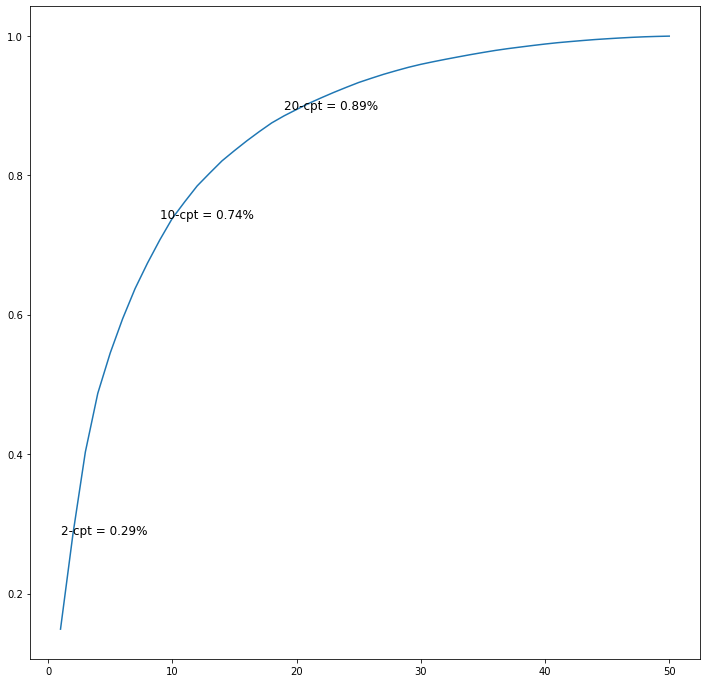

In [87]:
pca = PCA(n_components=50)
Y = pca.fit_transform(X)

cumulative = np.cumsum( pca.explained_variance_ratio_ )

fig = plt.figure(figsize=(12,12))
plt.plot(range(1,51), cumulative);
for i in [2,10,20]:
    plt.text(i-1, cumulative[i-1], "{}-cpt = {:.2f}%".format(i,cumulative[i-1]), fontsize='large' )
plt.show()

Clustering works well only in small dimensions. 20 might be too big, so PCA is probably a bad method here.

### Do some clustering

In [158]:
Xmm = MinMaxScaler().fit_transform(X)

pca = PCA(n_components=50)
Ypca = pca.fit_transform(Xmm)

se = SpectralEmbedding(n_components=10, n_neighbors=n_neighbors)
Yse = se.fit_transform(Xmm)

tsne = TSNE(n_components=2, init='pca', learning_rate='auto')      
Ytsne = tsne.fit_transform(Xmm)

In [159]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import accuracy_score, silhouette_score

def cluster_silhouette(Y, x):
    s = []
    for n_clusters in x:
        clusterer = KMeans(n_clusters=n_clusters)    
        cluster_labels = clusterer.fit_predict(Y)
        sil = silhouette_score(Y, cluster_labels)
        s.append(sil)
    return s

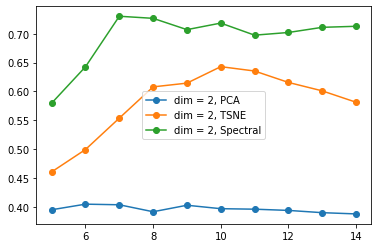

In [164]:
dim = 2
x = range(5,15)
plt.plot(x, cluster_silhouette(Ypca[:,:dim], x), marker='o', label='dim = {}, PCA'.format(dim))
plt.plot(x, cluster_silhouette(Ytsne, x), marker='o', label='dim = {}, TSNE'.format(dim))
plt.plot(x, cluster_silhouette(Yse[:,:dim], x), marker='o', label='dim = {}, Spectral'.format(dim))
plt.legend()
plt.show()

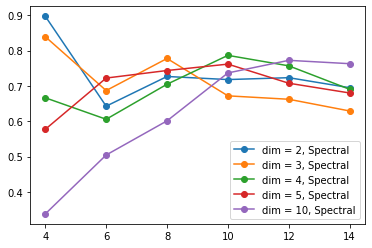

In [165]:
for dim in [2,3,4,5,10]:
    x = range(4,16,2)
    plt.plot(x, cluster_silhouette(Yse[:,:dim], x), marker='o', label='dim = {}, Spectral'.format(dim))
plt.legend()
plt.show()

Surprising that Spectral has a better score than TSNE, given the plots below!

In [167]:
dim=2
clusterer = KMeans(n_clusters=10)  
cluster_labels_se = clusterer.fit_predict(Yse[:,:dim])
cluster_labels_tsne = clusterer.fit_predict(Ytsne[:,:dim])

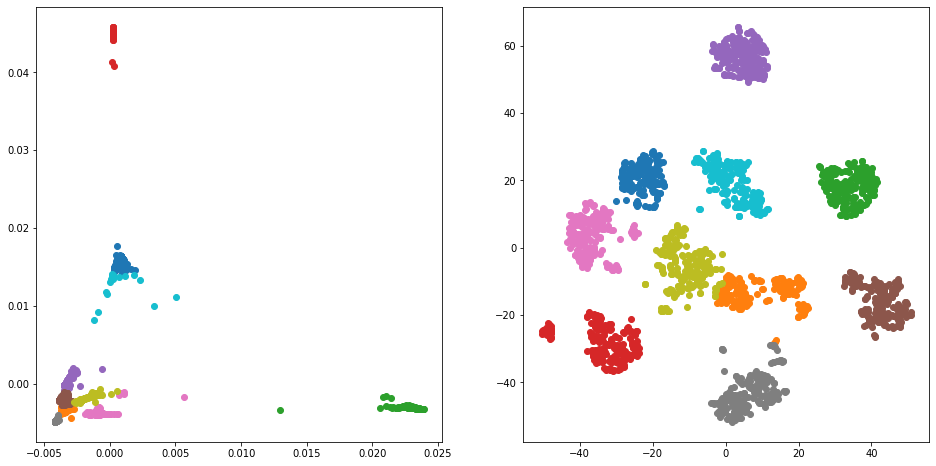

In [172]:
fig, ax = plt.subplots(1,2,figsize=(16,8))


for digit in range(10):
    p = Yse[cluster_labels_se == digit]
    ax[0].scatter(p[:,0],p[:,1],color=plt.cm.tab10(digit))

    p = Ytsne[cluster_labels_tsne == digit]
    ax[1].scatter(p[:,0],p[:,1],color=plt.cm.tab10(digit))
plt.show()